## Motion Correction demo

This notebook demonstrates the varios routines for motion correction in the CaImAn package. It demonstrates the usage of rigid and piecewise rigid motion correction on a two-photon calcium imaging dataset using the NoRMCorre algorithm [[1]](#normcorre), as well as several measures for quality assessment. This notebook should be interpreted more as a tutorial of the various methods. In practice, you can use either rigid or piecewise rigid motion correction depending on the motion of the dataset.

The dataset used in this notebook is provided by Sue Ann Koay and David Tank, Princeton University. This is a two photon calcium imaging dataset. For motion correction of one photon microendoscopic data the procedure is similar, with the difference, that the shifts are inferred on high pass spatially filtered version of the data. For more information check the demos for one photon data in the CaImAn package.

More information about the NoRMCorre algorithm can be found in the following paper:

<a name="normcorre"></a>[1] Pnevmatikakis, E.A., and Giovannucci A. (2017). NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data. Journal of Neuroscience Methods, 291:83-92 [[paper]](https://doi.org/10.1016/j.jneumeth.2017.07.031)

In [1]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
import cv2
try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
import numpy as np
import os
import glob
import time
import matplotlib.pyplot as plt
import psutil
import sys
from ipyparallel import Client
from skimage.external.tifffile import TiffFile
import scipy

from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

First download the file and load it in memory to view it. Note that it is not necessary to load the file in memory in order to perform motion correction. Here we load it to inspect it. Viewing the file occurs with OpenCV and will a open a new window. **To exit click on the video and press q.**

In [2]:
fname = 'Sue_2x_3000_40_-46.tif'
download_demo(fname)     # the file will be downloaded if it doesn't already exist
fname = [os.path.join('example_movies',fname)]
m_orig = cm.load_movie_chain(fname)
downsample_ratio = .2  # motion can be perceived better when downsampling in time
offset_mov = np.min(m_orig[:100])  # if the data has very negative values compute an offset value
m_orig.resize(1, 1, 0.2).play(
    gain=10, offset = -offset_mov, fr=30, magnification=2)   # play movie (press q to exit)

  0%|          | 0/1 [00:00<?, ?it/s]

File already downloaded


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


reshaping along z


Now set some parameters that are used for motion correction.

In [3]:
niter_rig = 1        # number of iterations for rigid motion correction
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
splits_rig =  56     # for parallelization split the movies in  num_splits chuncks across time
                     # if none all the splits are processed and the movie is saved
#num_splits_to_process_rig = None  # intervals at which patches are laid out for motion correction
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
splits_els =  56     # for parallelization split the movies in  num_splits chuncks across time
#num_splits_to_process_els = [28, None]
upsample_factor_grid = 4  # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts

Note that here the data presented here has been downsampled in space by a factor of 2 to reduce the file size. As a result the spatial resolution is coarser here (around 2 microns per pixel). If we were operating at the original resolution, several of the parameters above, e.g., ```max_shifts, strides, overlaps, max_deviation_rigid```, could have been larger by a factor of 2.

###### Motion correction is performed in parallel on chunks taken across times.

We first a cluster. The default backend mode for parallel processing is through the multiprocessing package. To make sure that this package is viewable from everywhere before starting the notebook these commands need to be executed from the terminal:
```bash
   export MKL_NUM_THREADS=1
   export OPENBLAS_NUM_THREADS=1
   export VECLIB_MAXIMUM_THREADS=1  
   ```
The last command is only specific to MAC OS. Note that this can be circumvented if ```backend = 'ipyparallel' ``` is chosen below. 

In [4]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    dview.terminate()
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
10
0
10
10
10
10
10
10
20
10
20
20
20
20
20
20
30
30
30
20
30
30
30
40
30
40
30
40
40
40
40
40
50
50
40
50
50
50
50
50
50
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
30
20
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
20
20
20
20
20
20
20
30
30
30
30
30
30
30
30
40
40
40
40
40
40
40
40
50
50
50
50
50
50
50
50
0
0
0
0
0
0
0
10
0
10
10
10
10
10
20
10
10
20
20
20
20
30
20
20
20
30
30
30
30
40
30
30
30
40
40
40
40
50
40
40
40
50
50
50
50
50
50
50
0
0
0
0
0
0
0
10
0
10
10
10
10
10
10
20
20
10
20
20
20
20
20
30
30
20
30
30
30
30
30
40
30
40
40
40
40
40
40
50
40
50
50
50
50
50
50
50
0
0
0
10
0
10
10
20
10
20
20
30
20
30
30
40
30
40
40
50
40
50
50
50
0
0
0
0
10
10
10
10
20
20
20
30
20
30
40
30
30
40
40
50
40
50
50
50


Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


We first need to create a motion correction object with the parameters specified above

In [5]:
# create a motion correction object
mc = MotionCorrect(fname[0], offset_mov,
                   dview = dview, max_shifts = max_shifts, niter_rig = niter_rig,
                   splits_rig = splits_rig, 
                   strides = strides, overlaps= overlaps, splits_els = splits_els,
                   upsample_factor_grid = upsample_factor_grid,
                   max_deviation_rigid = max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)

<h1> Rigid motion correction</h1>
<p> The original file exhibits a lot of motion. In order to correct for it we are first trying a simple rigid motion correction algorithm. This algorithm first creates a template by averaging frames from the video. It then tries to match each frame to this template. In addition the template will get updated during the matching process. Making it more precise and so does the template matching.  </p>
<img src="docs/img/rigidcorrection.png" />

Rigid Motion Correction
296.0
-296.0
Frame 100


/Users/epnevmatikakis/Documents/Python/github/CaImAn/caiman/base/movies.py:257: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  warnings.warn('** Pixels averages are too negative. Removing 1 percentile. **')
/Users/epnevmatikakis/Documents/Python/github/CaImAn/caiman/base/movies.py:275: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  warnings.warn('Pixels averages are too negative for template. Removing 1 percentile.')


Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-296.0
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Adding to movie 296.0
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
nan
mmap


/Users/epnevmatikakis/anaconda3/envs/caiman3/lib/python3.5/site-packages/numpy/linalg/linalg.py:2168: RuntimeWarning: invalid value encountered in sqrt
  ret = sqrt(sqnorm)


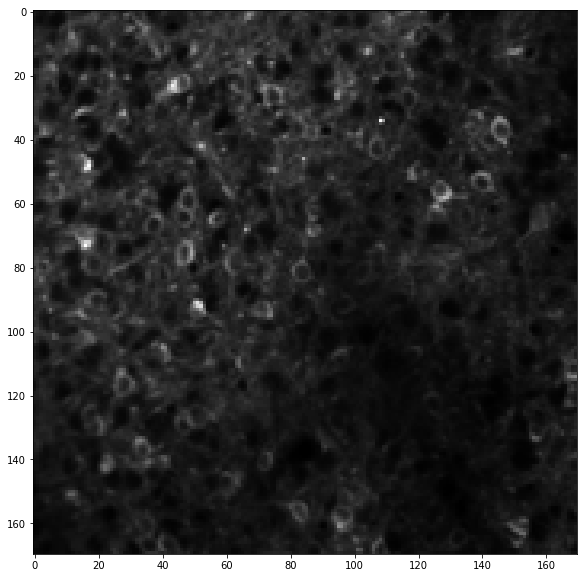

In [6]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct_rigid(save_movie=True)
# load motion corrected movie
m_rig = cm.load(mc.fname_tot_rig)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)
#%% visualize templates
plt.figure(figsize = (20,10))
plt.imshow(mc.total_template_rig, cmap = 'gray')

In [7]:
#%% inspect movie
m_rig.resize(1, 1, downsample_ratio).play(
    gain=10, offset = 0, fr=30, magnification=2,bord_px = bord_px_rig) # press q to exit

reshaping along z


plot the shifts computed by rigid registration

Text(0,0.5,'pixels')

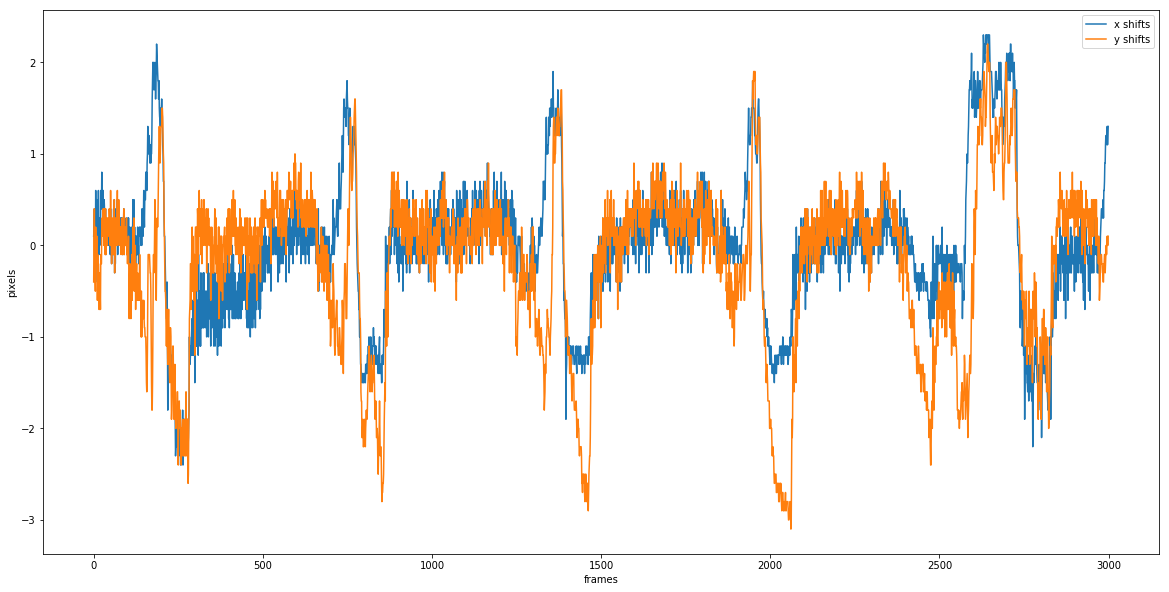

In [13]:
#%% plot rigid shifts
plt.close()
plt.figure(figsize = (20,10))
plt.plot(mc.shifts_rig)
plt.legend(['x shifts','y shifts'])
plt.xlabel('frames')
plt.ylabel('pixels')

## Piecewise rigid motion correction with NoRMCorre
The rigidly registered movie has corrected for a lot of the original motion. However, since non-rigid motion still exists and needs to be corrected. To do that we use the NoRMCorre algorithm for piecewise rigid registration. The FOV is split in overlapping patches and a rigid displacement vector is estimated for each patch. The estimated shifts are subsequently up-sampled to create a smooth motion field for each frame that can efficiently approximate non-rigid motion in a piecewise-rigid manner. For more information see [[1]](#normcorre)
<img src="docs\img\pwrigidcorrection.png" />

In [14]:
%%capture
#%% motion correct piecewise rigid
mc.motion_correct_pwrigid(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.resize(1, 1, downsample_ratio).play(
    gain=10, offset = 0, fr=30, magnification=2,bord_px = bord_px_rig)

Now concatenate all the movies (raw, rigid, and pw-rigid) for inspection

In [15]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)-offset_mov,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
    1, 1, downsample_ratio)], axis=2).play(fr=60, gain=15, magnification=2, offset=0)

reshaping along z
reshaping along z
reshaping along z


From the movie we can see that pw-rigid registration corrected for the non elastic motion of the data. This was done by estimating different displacement vectors for the different patches in the FOV. This can be visualized by plotting all the computed shifts were a dispersion in the shifts in the y direction is apparent.

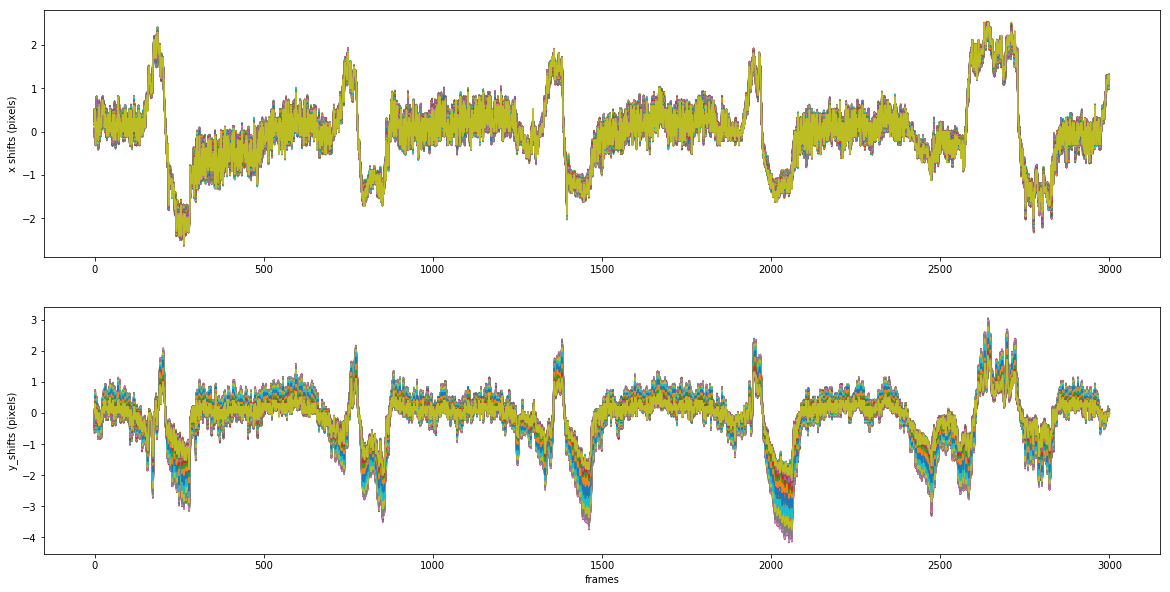

In [16]:
#%% visualize elastic shifts
plt.close()
plt.figure(figsize = (20,10))
plt.subplot(2, 1, 1)
plt.plot(mc.x_shifts_els)
plt.ylabel('x shifts (pixels)')
plt.subplot(2, 1, 2)
plt.plot(mc.y_shifts_els)
plt.ylabel('y_shifts (pixels)')
plt.xlabel('frames')
#%% compute borders to exclude
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

The improvement in performance can also be seen by a more crisp summary statistic image. Below we plot the correlation images for the three datasets.

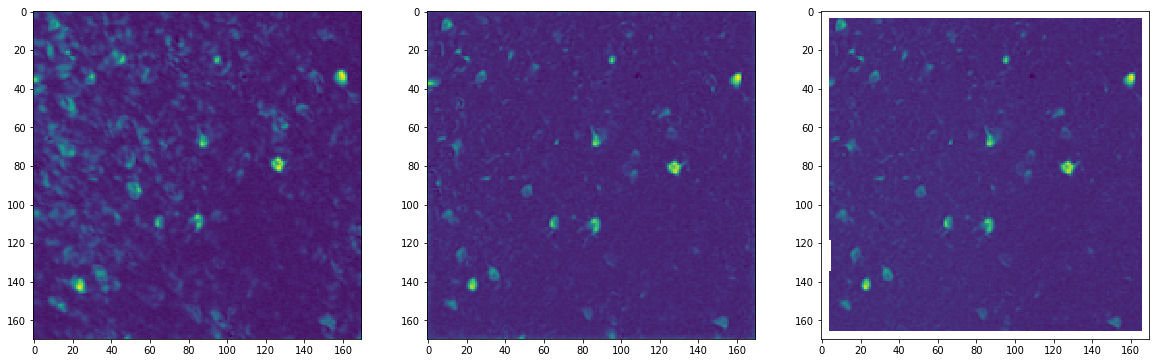

In [17]:
plt.figure(figsize = (20,10))
plt.subplot(1,3,1); plt.imshow(m_orig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,2); plt.imshow(m_rig.local_correlations(eight_neighbours=True, swap_dim=False))
plt.subplot(1,3,3); plt.imshow(m_els.local_correlations(eight_neighbours=True, swap_dim=False))

## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [33]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fname[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els, final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

Plot correlation with mean frame for each dataset

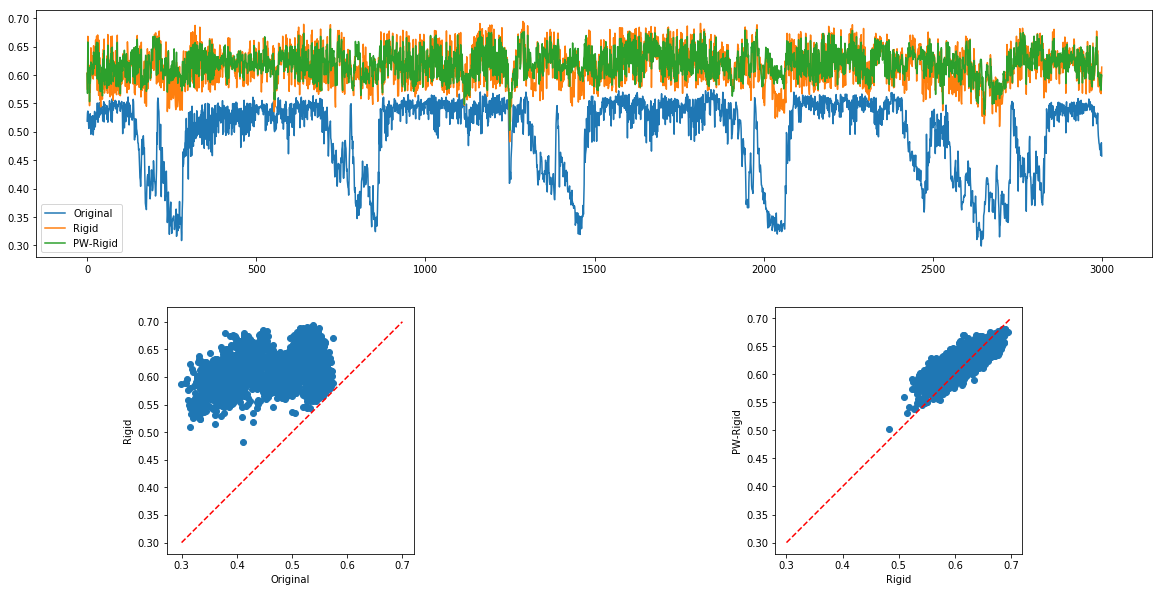

In [34]:
plt.figure(figsize = (20,10))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [35]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 1830
Crispness rigid: 2608
Crispness elastic: 2677


['smoothness', 'norms', 'correlations', 'img_corr', 'smoothness_corr', 'tmpl', 'flows']
example_movies/Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000_._metrics.npz
nan+/-nan ; 2677.220947265625 ; 4.648357173314064
mmap
['smoothness', 'norms', 'correlations', 'img_corr', 'smoothness_corr', 'tmpl', 'flows']
example_movies/Sue_2x_3000_40_-46_rig__d1_170_d2_170_d3_1_order_F_frames_3000_._metrics.npz
nan+/-nan ; 2608.493408203125 ; 4.672018974654127
mmap
['smoothness', 'norms', 'correlations', 'img_corr', 'smoothness_corr', 'tmpl', 'flows']
example_movies/Sue_2x_3000_40_-46_metrics.npz
nan+/-nan ; 1830.1502685546875 ; 5.3890866024303365
File is:
example_movies/Sue_2x_3000_40_-46mmap


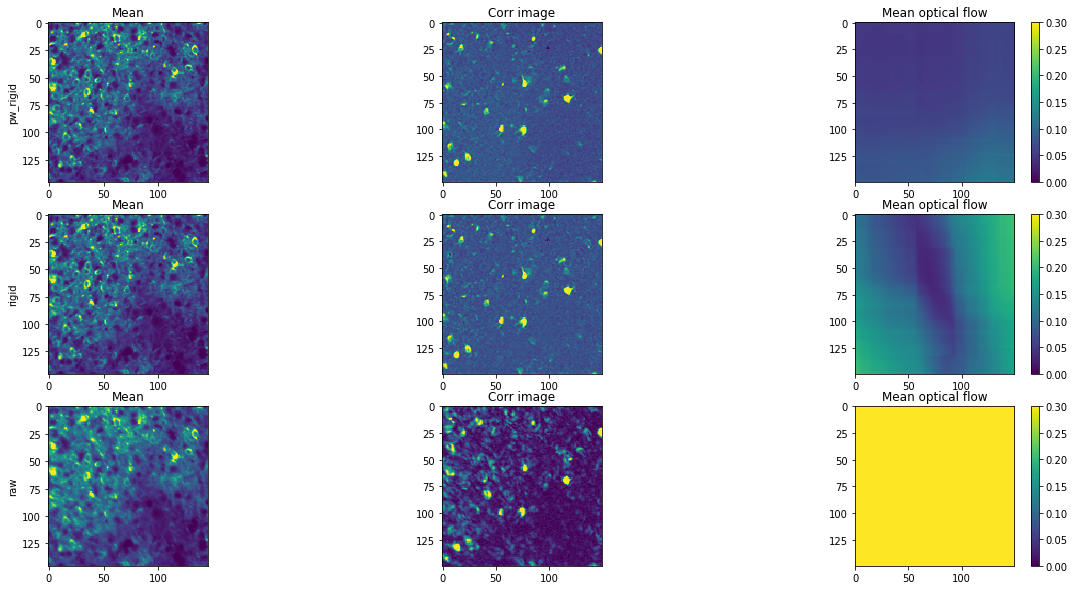

In [36]:
#%% plot the results of Residual Optical Flow
fls = [mc.fname_tot_els[:-4] + '_metrics.npz', mc.fname_tot_rig[:-4] +
       '_metrics.npz', mc.fname[:-4] + '_metrics.npz']

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')      